# Chapter 15: Self-Attention and Transformers
Classification with a transformer encoder. We train a BERT-like classifier from scratch with the SST-2 dataset. There is no pretraining and we should not expect a high performance.

Programs from the book: [_Python for Natural Language Processing_](https://link.springer.com/book/9783031575488)

__Author__: Pierre Nugues

## Preliminaries
### Modules

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, TensorDataset, DataLoader

from collections import Counter
from datasets import load_dataset

from tqdm import tqdm
import matplotlib.pyplot as plt

### Seeds

In [2]:
torch.manual_seed(1234)

### Constants

In [3]:
SMALL = False

D_MODEL = 128
NUM_LAYERS = 2
NHEAD = 4

MAX_LEN = 512  # Max length of a sequence. See BERT. Experiments use either 128 or 512
VOCAB_SIZE = 30000  # Vocabulary size as in BERT

BATCH_SIZE = 32
LR = 0.001
EPOCHS = 15

CLS_TOKEN = True  # How to classify: CLS_TOKEN or max of embeddings

In [4]:
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')
device

device(type='mps')

Disabling device. When runnning om MPS, I get: `MPS backend out of memory`

## Dataset

### SST2

In [5]:
sst2 = load_dataset('sst2')
sst2

DatasetDict({
    train: Dataset({
        features: ['idx', 'sentence', 'label'],
        num_rows: 67349
    })
    validation: Dataset({
        features: ['idx', 'sentence', 'label'],
        num_rows: 872
    })
    test: Dataset({
        features: ['idx', 'sentence', 'label'],
        num_rows: 1821
    })
})

We can extract a small dataset for testing the whole pipeline

In [6]:
if SMALL:
    sst2['train'] = sst2['train'].select(range(0, 67349, 10))

The dataset structure

In [7]:
sst2

DatasetDict({
    train: Dataset({
        features: ['idx', 'sentence', 'label'],
        num_rows: 67349
    })
    validation: Dataset({
        features: ['idx', 'sentence', 'label'],
        num_rows: 872
    })
    test: Dataset({
        features: ['idx', 'sentence', 'label'],
        num_rows: 1821
    })
})

We convert them into dictionaries

In [8]:
def to_dict(dataset):
    new_ds = []
    for review in dataset:
        new_ds += [review]
    return new_ds

In [9]:
train_set = to_dict(sst2['train'])
val_set = to_dict(sst2['validation'])
test_set = to_dict(sst2['test'])

In [10]:
train_set[:3]

[{'idx': 0,
  'sentence': 'hide new secretions from the parental units ',
  'label': 0},
 {'idx': 1, 'sentence': 'contains no wit , only labored gags ', 'label': 0},
 {'idx': 2,
  'sentence': 'that loves its characters and communicates something rather beautiful about human nature ',
  'label': 1}]

In [11]:
train_set[100:110]

[{'idx': 100, 'sentence': 'in memory ', 'label': 1},
 {'idx': 101, 'sentence': 'respectable new one ', 'label': 1},
 {'idx': 102, 'sentence': 'yet this grating showcase ', 'label': 0},
 {'idx': 103,
  'sentence': 'hate to tear your eyes away from the images long enough to read the subtitles ',
  'label': 1},
 {'idx': 104,
  'sentence': 'addition to sporting one of the worst titles in recent cinematic history ',
  'label': 0},
 {'idx': 105,
  'sentence': ', this gender-bending comedy is generally quite funny . ',
  'label': 1},
 {'idx': 106,
  'sentence': "build some robots , haul 'em to the theater with you for the late show , and put on your own mystery science theatre 3000 tribute to what is almost certainly going to go down as the worst -- and only -- killer website movie of this or any other year ",
  'label': 0},
 {'idx': 107, 'sentence': "do n't work in concert ", 'label': 0},
 {'idx': 108,
  'sentence': 'the direction has a fluid , no-nonsense authority , and the performances by

In [12]:
train_set[3000]

{'idx': 3000,
 'sentence': 'buy is an accomplished actress , and this is a big , juicy role ',
 'label': 1}

In [13]:
if not SMALL:
    print(train_set[12500])

{'idx': 12500, 'sentence': "is of brian de palma 's addiction to the junk-calorie suspense tropes that have all but ruined his career ", 'label': 0}


In [14]:
len(train_set), len(val_set), len(test_set)

(67349, 872, 1821)

### Preprocessing the Dataset

In [15]:
words = []
for review in train_set:
    words += review['sentence'].split()

In [16]:
word_freqs = Counter(words)
word_freqs

Counter({'the': 27205,
         ',': 25980,
         'a': 21609,
         'and': 19920,
         'of': 17907,
         '.': 12687,
         'to': 12538,
         "'s": 8764,
         'is': 8685,
         'that': 7759,
         'in': 7495,
         'it': 7078,
         'as': 5088,
         'with': 4745,
         'an': 4133,
         'film': 4038,
         'its': 3924,
         'for': 3913,
         'movie': 3563,
         'this': 3365,
         'you': 2749,
         'but': 2690,
         'be': 2671,
         'on': 2456,
         "n't": 2311,
         'by': 2211,
         'more': 2124,
         '--': 2108,
         'one': 2031,
         'at': 2011,
         'than': 1994,
         'has': 1886,
         'not': 1886,
         'about': 1862,
         'his': 1860,
         'from': 1859,
         'are': 1812,
         'like': 1782,
         'so': 1712,
         'or': 1710,
         'all': 1682,
         'have': 1671,
         'most': 1516,
         'story': 1398,
         "'": 1375,
         '

In [17]:
len(word_freqs)

14816

In [18]:
word_freqs.most_common(VOCAB_SIZE)

[('the', 27205),
 (',', 25980),
 ('a', 21609),
 ('and', 19920),
 ('of', 17907),
 ('.', 12687),
 ('to', 12538),
 ("'s", 8764),
 ('is', 8685),
 ('that', 7759),
 ('in', 7495),
 ('it', 7078),
 ('as', 5088),
 ('with', 4745),
 ('an', 4133),
 ('film', 4038),
 ('its', 3924),
 ('for', 3913),
 ('movie', 3563),
 ('this', 3365),
 ('you', 2749),
 ('but', 2690),
 ('be', 2671),
 ('on', 2456),
 ("n't", 2311),
 ('by', 2211),
 ('more', 2124),
 ('--', 2108),
 ('one', 2031),
 ('at', 2011),
 ('than', 1994),
 ('has', 1886),
 ('not', 1886),
 ('about', 1862),
 ('his', 1860),
 ('from', 1859),
 ('are', 1812),
 ('like', 1782),
 ('so', 1712),
 ('or', 1710),
 ('all', 1682),
 ('have', 1671),
 ('most', 1516),
 ('story', 1398),
 ("'", 1375),
 ('good', 1341),
 ('...', 1331),
 ('into', 1314),
 ('out', 1282),
 ('too', 1280),
 ('who', 1271),
 (')', 1179),
 ('up', 1161),
 ('characters', 1136),
 ('i', 1113),
 ('funny', 1105),
 ('(', 1074),
 ('comedy', 1053),
 ('if', 1050),
 ('just', 1050),
 ('no', 1035),
 ('does', 1009),
 

In [19]:
token2idx = {k: i for i, (k, v) in enumerate(
    word_freqs.most_common(VOCAB_SIZE), start=3)}

In [20]:
token2idx

{'the': 3,
 ',': 4,
 'a': 5,
 'and': 6,
 'of': 7,
 '.': 8,
 'to': 9,
 "'s": 10,
 'is': 11,
 'that': 12,
 'in': 13,
 'it': 14,
 'as': 15,
 'with': 16,
 'an': 17,
 'film': 18,
 'its': 19,
 'for': 20,
 'movie': 21,
 'this': 22,
 'you': 23,
 'but': 24,
 'be': 25,
 'on': 26,
 "n't": 27,
 'by': 28,
 'more': 29,
 '--': 30,
 'one': 31,
 'at': 32,
 'than': 33,
 'has': 34,
 'not': 35,
 'about': 36,
 'his': 37,
 'from': 38,
 'are': 39,
 'like': 40,
 'so': 41,
 'or': 42,
 'all': 43,
 'have': 44,
 'most': 45,
 'story': 46,
 "'": 47,
 'good': 48,
 '...': 49,
 'into': 50,
 'out': 51,
 'too': 52,
 'who': 53,
 ')': 54,
 'up': 55,
 'characters': 56,
 'i': 57,
 'funny': 58,
 '(': 59,
 'comedy': 60,
 'if': 61,
 'just': 62,
 'no': 63,
 'does': 64,
 'much': 65,
 'what': 66,
 'can': 67,
 'even': 68,
 '`': 69,
 'your': 70,
 'their': 71,
 'will': 72,
 'time': 73,
 'some': 74,
 'bad': 75,
 '``': 76,
 'little': 77,
 "''": 78,
 'very': 79,
 'way': 80,
 'which': 81,
 'best': 82,
 'any': 83,
 'love': 84,
 'been': 8

In [21]:
token2idx['[PAD]'] = 0
token2idx['[UNK]'] = 1
token2idx['[CLS]'] = 2

In [22]:
idx2token = {v: k for k, v in token2idx.items()}

In [23]:
idx2token[0]

'[PAD]'

In [24]:
sorted(idx2token.items(), key=lambda x: x)

[(0, '[PAD]'),
 (1, '[UNK]'),
 (2, '[CLS]'),
 (3, 'the'),
 (4, ','),
 (5, 'a'),
 (6, 'and'),
 (7, 'of'),
 (8, '.'),
 (9, 'to'),
 (10, "'s"),
 (11, 'is'),
 (12, 'that'),
 (13, 'in'),
 (14, 'it'),
 (15, 'as'),
 (16, 'with'),
 (17, 'an'),
 (18, 'film'),
 (19, 'its'),
 (20, 'for'),
 (21, 'movie'),
 (22, 'this'),
 (23, 'you'),
 (24, 'but'),
 (25, 'be'),
 (26, 'on'),
 (27, "n't"),
 (28, 'by'),
 (29, 'more'),
 (30, '--'),
 (31, 'one'),
 (32, 'at'),
 (33, 'than'),
 (34, 'has'),
 (35, 'not'),
 (36, 'about'),
 (37, 'his'),
 (38, 'from'),
 (39, 'are'),
 (40, 'like'),
 (41, 'so'),
 (42, 'or'),
 (43, 'all'),
 (44, 'have'),
 (45, 'most'),
 (46, 'story'),
 (47, "'"),
 (48, 'good'),
 (49, '...'),
 (50, 'into'),
 (51, 'out'),
 (52, 'too'),
 (53, 'who'),
 (54, ')'),
 (55, 'up'),
 (56, 'characters'),
 (57, 'i'),
 (58, 'funny'),
 (59, '('),
 (60, 'comedy'),
 (61, 'if'),
 (62, 'just'),
 (63, 'no'),
 (64, 'does'),
 (65, 'much'),
 (66, 'what'),
 (67, 'can'),
 (68, 'even'),
 (69, '`'),
 (70, 'your'),
 (71, 't

In [25]:
train_set

[{'idx': 0,
  'sentence': 'hide new secretions from the parental units ',
  'label': 0},
 {'idx': 1, 'sentence': 'contains no wit , only labored gags ', 'label': 0},
 {'idx': 2,
  'sentence': 'that loves its characters and communicates something rather beautiful about human nature ',
  'label': 1},
 {'idx': 3,
  'sentence': 'remains utterly satisfied to remain the same throughout ',
  'label': 0},
 {'idx': 4,
  'sentence': 'on the worst revenge-of-the-nerds clichés the filmmakers could dredge up ',
  'label': 0},
 {'idx': 5,
  'sentence': "that 's far too tragic to merit such superficial treatment ",
  'label': 0},
 {'idx': 6,
  'sentence': 'demonstrates that the director of such hollywood blockbusters as patriot games can still turn out a small , personal film with an emotional wallop . ',
  'label': 1},
 {'idx': 7, 'sentence': 'of saucy ', 'label': 1},
 {'idx': 8,
  'sentence': "a depressed fifteen-year-old 's suicidal poetry ",
  'label': 0},
 {'idx': 9,
  'sentence': "are more deep

In [26]:
def sent2idx(dataset, token2idx, max_len, cls_token=CLS_TOKEN):
    for review in dataset:
        tokens = review['sentence'].split()
        if cls_token:
            idx = [token2idx['[CLS]']]  # We start with a CLS
        else:
            idx = []
        for token in tokens:
            if token in token2idx:
                idx += [token2idx[token]]
            else:
                idx += [token2idx['[UNK]']]
        review['word_idx'] = torch.tensor(idx)[:max_len]
    return dataset

In [27]:
train_set = sent2idx(train_set, token2idx, MAX_LEN, cls_token=CLS_TOKEN)
val_set = sent2idx(val_set, token2idx, MAX_LEN, cls_token=CLS_TOKEN)
test_set = sent2idx(test_set, token2idx, MAX_LEN, cls_token=CLS_TOKEN)

In [28]:
train_set[3000]

{'idx': 3000,
 'sentence': 'buy is an accomplished actress , and this is a big , juicy role ',
 'label': 1,
 'word_idx': tensor([   2, 1835,   11,   17, 1247,  753,    4,    6,   22,   11,    5,  173,
            4, 3239,  529])}

In [29]:
len(train_set), len(val_set), len(test_set)

(67349, 872, 1821)

### PyTorch Datasets

In [30]:
class ClassificationDataset(Dataset):
    def __init__(self, src_seqs, tgt_seqs):
        self.src_seqs = src_seqs
        self.tgt_seqs = tgt_seqs

    def __len__(self):
        return len(self.src_seqs)

    def __getitem__(self, idx):
        return self.src_seqs[idx], self.tgt_seqs[idx]

    def collate(self, batch):
        src_batch, tgt_batch = list(zip(*batch))
        src_batch = pad_sequence(src_batch,
                                 batch_first=True,
                                 padding_value=0)
        tgt_batch = torch.tensor(tgt_batch)
        return src_batch, tgt_batch

In [31]:
X_train = [record['word_idx'] for record in train_set]
y_train = [record['label'] for record in train_set]
X_val = [record['word_idx'] for record in val_set]
y_val = [record['label'] for record in val_set]

In [32]:
train_dataset = ClassificationDataset(X_train, y_train)
train_dataloader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=train_dataset.collate)
val_dataset = ClassificationDataset(X_val, y_val)
val_dataloader = DataLoader(
    val_dataset, batch_size=BATCH_SIZE, shuffle=False,
    collate_fn=val_dataset.collate)

Alternate code, where we pad the complete dataset to the same length. This would waste space

In [33]:
"""
X_train = pad_sequence([record['word_idx'] for record in train_set],
                       batch_first=True)
y_train = torch.tensor([record['label'] for record in train_set])
X_val = pad_sequence([record['word_idx'] for record in val_set],
                     batch_first=True)
y_val = torch.tensor([record['label'] for record in val_set])
"""

"\nX_train = pad_sequence([record['word_idx'] for record in train_set],\n                       batch_first=True)\ny_train = torch.tensor([record['label'] for record in train_set])\nX_val = pad_sequence([record['word_idx'] for record in val_set],\n                     batch_first=True)\ny_val = torch.tensor([record['label'] for record in val_set])\n"

In [34]:
"""
train_dataset = TensorDataset(X_train, y_train)
train_dataloader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataset = TensorDataset(X_val, y_val)
val_dataloader = DataLoader(
    val_dataset, batch_size=BATCH_SIZE, shuffle=False)
"""

'\ntrain_dataset = TensorDataset(X_train, y_train)\ntrain_dataloader = DataLoader(\n    train_dataset, batch_size=BATCH_SIZE, shuffle=True)\nval_dataset = TensorDataset(X_val, y_val)\nval_dataloader = DataLoader(\n    val_dataset, batch_size=BATCH_SIZE, shuffle=False)\n'

## Transformer Encoder
We create transformer encoder with BERT-like position encoding. We add the word embeddings and the position encoding

In [35]:
class EncoderClassifier(nn.Module):
    def __init__(self,
                 vocab_size,
                 max_len,
                 d_model,
                 nhead,
                 num_layers,
                 num_class=2,
                 dropout=0.2,
                 cls_token=CLS_TOKEN):
        super().__init__()
        self.cls_token = cls_token
        self.token_embeddings = nn.Embedding(
            vocab_size, d_model, padding_idx=0)
        self.position_embeddings = nn.Embedding(
            max_len, d_model)
        self.encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            batch_first=True,
            dropout=dropout
        )
        self.encoder = nn.TransformerEncoder(
            encoder_layer=self.encoder_layer,
            num_layers=num_layers
        )
        self.fc = nn.Linear(d_model, num_class)
        self.dropout = nn.Dropout(dropout)

    def forward(self, X):
        src_padding_mask = (X == 0)
        X = self.token_embeddings(X)
        idx = torch.arange(X.size()[1])
        pos = self.position_embeddings(idx).unsqueeze(dim=0)
        X = X + pos
        X = self.encoder(X, src_key_padding_mask=src_padding_mask)
        X = self.dropout(X)
        if self.cls_token:
            X = X[:, 0, :]
        else:
            X, _ = X.max(dim=1)
        X = self.fc(X)
        return X

In [36]:
bert = EncoderClassifier(
    len(idx2token),
    max_len=MAX_LEN,
    d_model=D_MODEL,
    nhead=NHEAD,
    num_layers=NUM_LAYERS,
)  # .to(device)
bert

EncoderClassifier(
  (token_embeddings): Embedding(14819, 128, padding_idx=0)
  (position_embeddings): Embedding(512, 128)
  (encoder_layer): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
    )
    (linear1): Linear(in_features=128, out_features=2048, bias=True)
    (dropout): Dropout(p=0.2, inplace=False)
    (linear2): Linear(in_features=2048, out_features=128, bias=True)
    (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.2, inplace=False)
    (dropout2): Dropout(p=0.2, inplace=False)
  )
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_

In [37]:
params = sum(p.numel() for p in bert.parameters())
print(f"{params:,} parameters.")
trainable_params = sum(
    p.numel() for p in bert.parameters() if p.requires_grad)
print(f"{trainable_params:,} trainable parameters.\n")

3,741,698 parameters.
3,741,698 trainable parameters.



In [38]:
X_train[:4]

[tensor([    2,  4458,    95, 12430,    38,     3,  7262,  9002]),
 tensor([   2, 2904,   63,  328,    4,   91, 1971,  550]),
 tensor([   2,   12, 1770,   19,   56,    6, 5992,   98,  186,  267,   36,  180,
          624]),
 tensor([   2,  595,  675, 5993,    9, 1972,    3,  291,  698])]

In [39]:
bert(pad_sequence(X_train[:4], batch_first=True))

tensor([[ 0.5714, -0.9533],
        [ 1.0908, -1.0189],
        [ 0.9830, -0.6438],
        [ 1.0126, -1.2372]], grad_fn=<AddmmBackward0>)

In [40]:
y_train[:4]

[0, 0, 1, 0]

In [41]:
train_set[3000]['word_idx'].size()

torch.Size([15])

In [42]:
s_3000 = train_set[3000]['word_idx']
s_3000

tensor([   2, 1835,   11,   17, 1247,  753,    4,    6,   22,   11,    5,  173,
           4, 3239,  529])

In [43]:
bert(s_3000.unsqueeze(dim=0))

tensor([[-0.0282, -0.7287]], grad_fn=<AddmmBackward0>)

### Training the Transformer

In [44]:
loss_fn = nn.CrossEntropyLoss(reduction='sum')
optimizer = optim.Adam(
    bert.parameters(),
    lr=LR,
)

In [45]:
train_set[0]

{'idx': 0,
 'sentence': 'hide new secretions from the parental units ',
 'label': 0,
 'word_idx': tensor([    2,  4458,    95, 12430,    38,     3,  7262,  9002])}

In [46]:
def accuracy(y_pred, y):
    acc = torch.sum(y == torch.argmax(y_pred, dim=-1))
    return acc.item()

In [47]:
def evaluate(model,
             loss_fn,
             dataloader) -> tuple[float, float]:
    model.eval()
    val_loss = 0
    val_acc = 0
    with torch.no_grad():
        for X_batch, y_batch in tqdm(dataloader):
            y_batch_pred = model(X_batch)
            loss = loss_fn(y_batch_pred, y_batch)
            val_loss += loss.item()
            val_acc += accuracy(y_batch_pred, y_batch)
        return val_loss/len(dataloader.sampler), val_acc/len(dataloader.sampler)

In [48]:
history = {}
history['accuracy'] = []
history['loss'] = []
history['val_accuracy'] = []
history['val_loss'] = []

In [49]:
best_loss = float('inf')
best_acc = 0.0
for epoch in range(EPOCHS):
    bert.train()
    train_loss = 0.0
    train_acc = 0
    for X_batch, y_batch in tqdm(train_dataloader):
        y_batch_pred = bert(X_batch)
        loss = loss_fn(y_batch_pred, y_batch)
        train_loss += loss.item()
        train_acc += accuracy(y_batch_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_loss /= len(train_dataloader.sampler)
    train_acc /= len(train_dataloader.sampler)
    history['loss'] += [train_loss]
    history['accuracy'] += [train_acc]

    val_loss, val_acc = evaluate(bert, loss_fn, val_dataloader)
    history['val_loss'] += [val_loss]
    history['val_accuracy'] += [val_acc]
    print('Epoch', epoch)
    print('Loss train and val.', train_loss, val_loss)
    print('Acc. train and val.', train_acc, val_acc)
    if val_acc > best_acc:
        best_acc = val_acc
        print('Best model (accuracy)')
        # torch.save(bert, 'models/bert_model_batch.pth')
    if val_loss < best_loss:
        best_loss = val_loss
        print('Best model (loss)')
        torch.save(bert, 'models/bert_model_batch.pth')

  0%|          | 0/28 [00:00<?, ?it/s]/opt/anaconda3/lib/python3.12/site-packages/torch/nn/modules/transformer.py:502: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/NestedTensorImpl.cpp:180.)
  output = torch._nested_tensor_from_mask(
100%|██████████| 28/28 [00:00<00:00, 87.92it/s]


Epoch 0
Loss train and val. 0.5850257483422052 0.48668307038622166
Acc. train and val. 0.6746351096527046 0.7752293577981652
Best model (accuracy)
Best model (loss)


100%|██████████| 28/28 [00:00<00:00, 100.04it/s]


Epoch 1
Loss train and val. 0.3443649324001286 0.5596466791739158
Acc. train and val. 0.8558256247308794 0.7970183486238532
Best model (accuracy)


100%|██████████| 28/28 [00:00<00:00, 93.39it/s]


Epoch 2
Loss train and val. 0.24778155415755065 0.45912843177077967
Acc. train and val. 0.9020326953629602 0.8096330275229358
Best model (accuracy)
Best model (loss)


100%|██████████| 28/28 [00:00<00:00, 92.54it/s]


Epoch 3
Loss train and val. 0.20184938427044305 0.5138119284166108
Acc. train and val. 0.9241859567328394 0.805045871559633


100%|██████████| 28/28 [00:00<00:00, 98.06it/s]


Epoch 4
Loss train and val. 0.17213316206654244 0.6701539664640339
Acc. train and val. 0.9360346849990349 0.7740825688073395


100%|██████████| 28/28 [00:00<00:00, 95.49it/s]


Epoch 5
Loss train and val. 0.15112347540357995 0.6255226430542972
Acc. train and val. 0.9435477883858706 0.7912844036697247


100%|██████████| 28/28 [00:00<00:00, 109.04it/s]


Epoch 6
Loss train and val. 0.1356509498067365 0.8252536042020955
Acc. train and val. 0.9492197360020194 0.7798165137614679


100%|██████████| 28/28 [00:00<00:00, 99.23it/s]


Epoch 7
Loss train and val. 0.12248554828448874 0.7707771054648478
Acc. train and val. 0.9546838111924453 0.7889908256880734


100%|██████████| 28/28 [00:00<00:00, 104.65it/s]


Epoch 8
Loss train and val. 0.11052956082292222 0.720818723833889
Acc. train and val. 0.9579058337911476 0.786697247706422


100%|██████████| 28/28 [00:00<00:00, 93.03it/s]


Epoch 9
Loss train and val. 0.10265859403288652 0.8393015962675077
Acc. train and val. 0.9618257138190619 0.7694954128440367


100%|██████████| 28/28 [00:00<00:00, 97.67it/s]


Epoch 10
Loss train and val. 0.09491348739291777 0.7956230075807746
Acc. train and val. 0.9639935262587418 0.7970183486238532


100%|██████████| 28/28 [00:00<00:00, 106.73it/s]


Epoch 11
Loss train and val. 0.0884069410228941 0.7866105356621086
Acc. train and val. 0.9658346820294288 0.7775229357798165


100%|██████████| 28/28 [00:00<00:00, 102.69it/s]


Epoch 12
Loss train and val. 0.08376961583920309 1.0485196682291293
Acc. train and val. 0.9681212787123789 0.7901376146788991


100%|██████████| 28/28 [00:00<00:00, 95.59it/s]


Epoch 13
Loss train and val. 0.07977358227820729 1.1409990650114663
Acc. train and val. 0.9697842581181606 0.7775229357798165


100%|██████████| 28/28 [00:00<00:00, 95.36it/s]

Epoch 14
Loss train and val. 0.07391461932612929 1.0898767100014817
Acc. train and val. 0.9709424044900444 0.7821100917431193


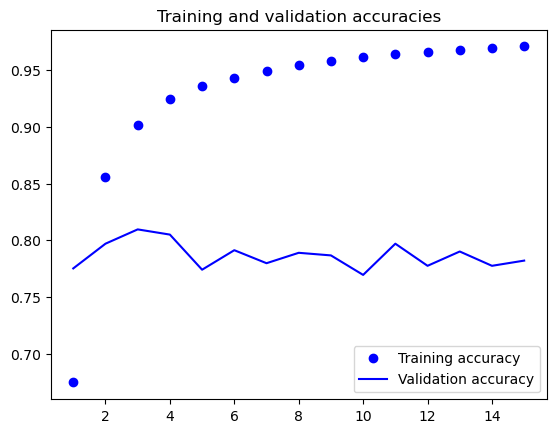

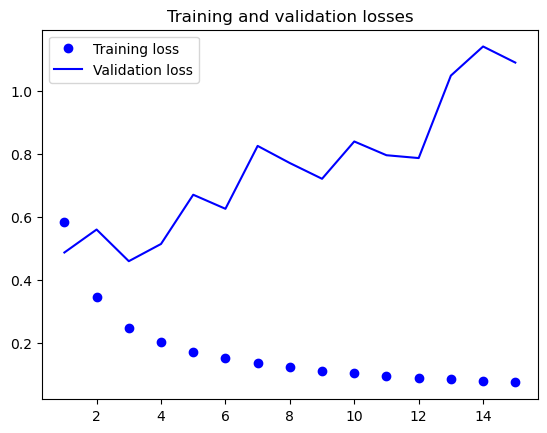

In [50]:
acc = history['accuracy']
loss = history['loss']
val_acc = history['val_accuracy']
val_loss = history['val_loss']

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracies')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation losses')
plt.legend()

plt.show()

In [51]:
trained_model = torch.load('models/bert_model_batch.pth')

/var/folders/29/s86dlfss3gq6ybhg4frthtxr0000gq/T/ipykernel_80644/3669437960.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  trained_model = torch.load('models/bert_model

## Evaluation

In [52]:
trained_model.eval()

EncoderClassifier(
  (token_embeddings): Embedding(14819, 128, padding_idx=0)
  (position_embeddings): Embedding(512, 128)
  (encoder_layer): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
    )
    (linear1): Linear(in_features=128, out_features=2048, bias=True)
    (dropout): Dropout(p=0.2, inplace=False)
    (linear2): Linear(in_features=2048, out_features=128, bias=True)
    (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.2, inplace=False)
    (dropout2): Dropout(p=0.2, inplace=False)
  )
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_

In [53]:
for record in test_set[:5]:
    sentence = record['sentence']
    sent_idx = list(map(lambda x: token2idx.get(x, 1), sentence.split()))
    with torch.no_grad():
        sentiment = torch.argmax(trained_model(
            torch.tensor(sent_idx).unsqueeze(dim=0))).item()
    print(sentiment, sentence)

0 uneasy mishmash of styles and genres .
0 this film 's relationship to actual tension is the same as what christmas-tree flocking in a spray can is to actual snow : a poor -- if durable -- imitation .
0 by the end of no such thing the audience , like beatrice , has a watchful affection for the monster .
1 director rob marshall went out gunning to make a great one .
1 lathan and diggs have considerable personal charm , and their screen rapport makes the old story seem new .


In [54]:
val_acc = 0
for record in val_set:
    sent_idx = record['word_idx']
    with torch.no_grad():
        sentiment = torch.argmax(trained_model(
            sent_idx.unsqueeze(dim=0))).item()
    if sentiment == record['label']:
        val_acc += 1
val_acc/len(val_set)

0.8096330275229358